In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

from utils import *

In [10]:
# Flow class
''' Note: PlanarFlows are only invertible under certain conditions, 
nevetheless we use them to illustrate the workflow of a simple model '''

class PlanarFlow(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # setup learnable pytorch parameters
        self.b = nn.Parameter(torch.Tensor(1, dim))
        self.w = nn.Parameter(torch.Tensor(dim, dim))
        self.u = nn.Parameter(torch.Tensor(1, dim))
        self.init_parameters()
    
    # flow function
    def __call__(self, z):
        linear = F.linear(z, self.w, self.b)
        return z + self.u * torch.tanh(linear)

    # compute log of the Jacobian's determinant
    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.w, self.b)
        psi = F.linear(1 - torch.tanh(f_z) ** 2, self.w)
        det_grad = 1 + torch.mm(psi, self.u.t())
        return torch.log(det_grad.abs() + 1e-9)

    # initialize pytorch parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)

# Main Model to wrap flows

class NormalizingFlow(nn.Module):
    def __init__(self, dim, n_flows):
        super().__init__()
        # stack PlanarFlow n_flows-th times
        flows = [ PlanarFlow(dim) for i in range(n_flows) ]
        self.flows = nn.ModuleList(flows)

    # generator function g(z)=y
    def forward(self, z):
        self.log_det = []
        for b in range(len(self.flows)):
            self.log_det.append(self.flows[b].log_abs_det_jacobian(z))
            z = self.flows[b](z)
        return z, self.log_det 

Iter. 0 Loss: 18.03571
Iter. 180 Loss: 16.69091
Iter. 360 Loss: 11.36957
Iter. 540 Loss: 7.69574
Iter. 720 Loss: 4.99109
Iter. 900 Loss: 4.29484
Iter. 1080 Loss: 3.81720
Iter. 1260 Loss: 3.51112
Iter. 1440 Loss: 2.95876
Iter. 1620 Loss: 2.95406
Iter. 1800 Loss: 3.01417


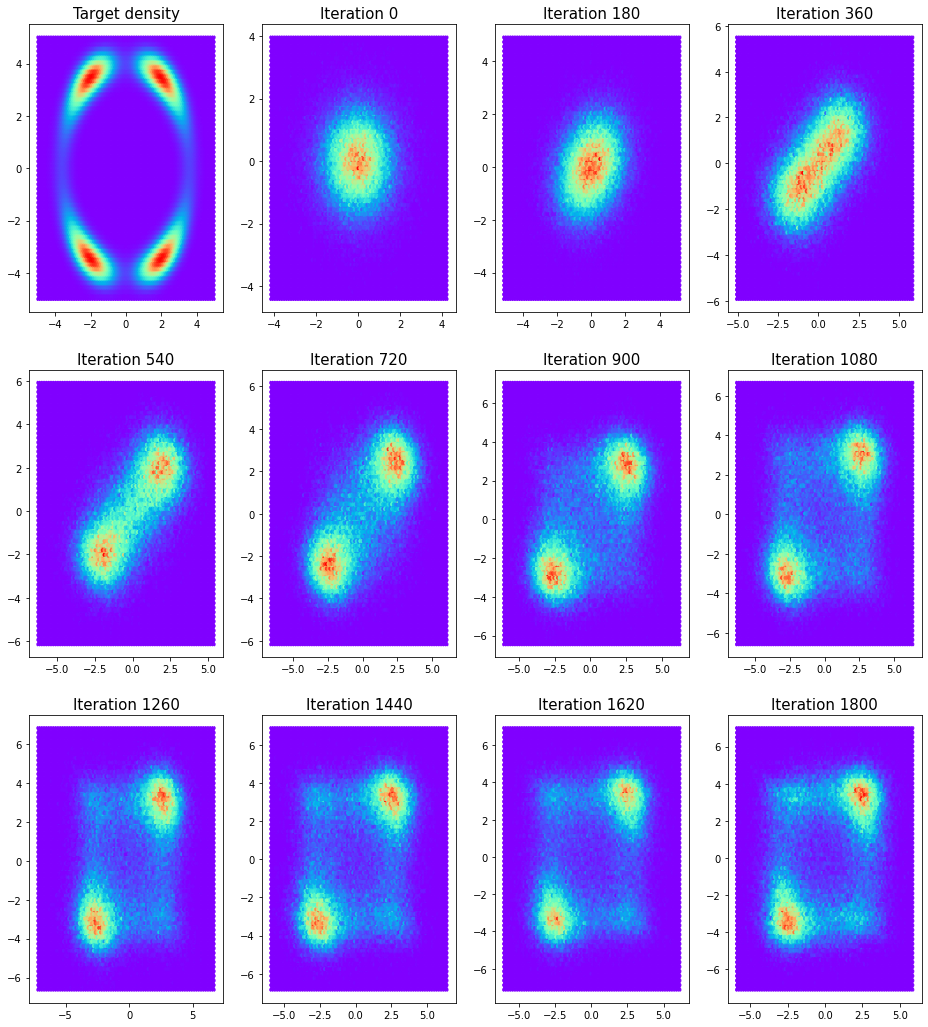

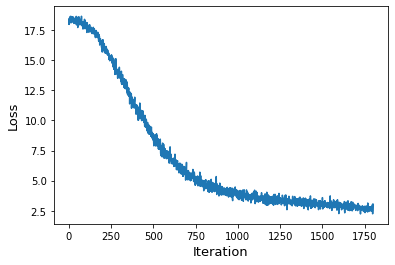

In [11]:
# Initialize and train the NormalizingFlow model
flow = NormalizingFlow(dim=2, n_flows=2)
train(model=flow,
      iterations=1801, 
      lr=0.001,
      name='simpleflow',
      jupyter_nb=True)

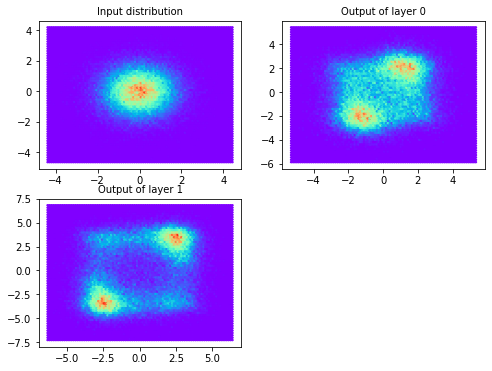

In [12]:
# Check the output of the stacked flow components
model_layerwise(flow, name='simplemodel')

# More complex flow using the FrEIA framework

In [13]:
# use https://github.com/VLL-HD/FrEIA from Visual Learning Lab Heidelberg
# !pip install git+https://github.com/VLL-HD/FrEIA.git #uncomment to install FrEIa
import FrEIA.framework as Ff
import FrEIA.modules as Fm

In [14]:
# Initialize FrEIA model and append some modules to it
inn = Ff.SequenceINN(2)
for k in range(8):
    inn.append(Fm.NICECouplingBlock, subnet_constructor=mlp_constructor)
    inn.append(Fm.PermuteRandom)


Iter. 0 Loss: 18.32340
Iter. 60 Loss: 1.41154
Iter. 120 Loss: 1.35853
Iter. 180 Loss: 1.10966
Iter. 240 Loss: 0.97240
Iter. 300 Loss: 1.05165
Iter. 360 Loss: 0.97121
Iter. 420 Loss: 1.04192
Iter. 480 Loss: 0.95628
Iter. 540 Loss: 1.00404
Iter. 600 Loss: 0.89929


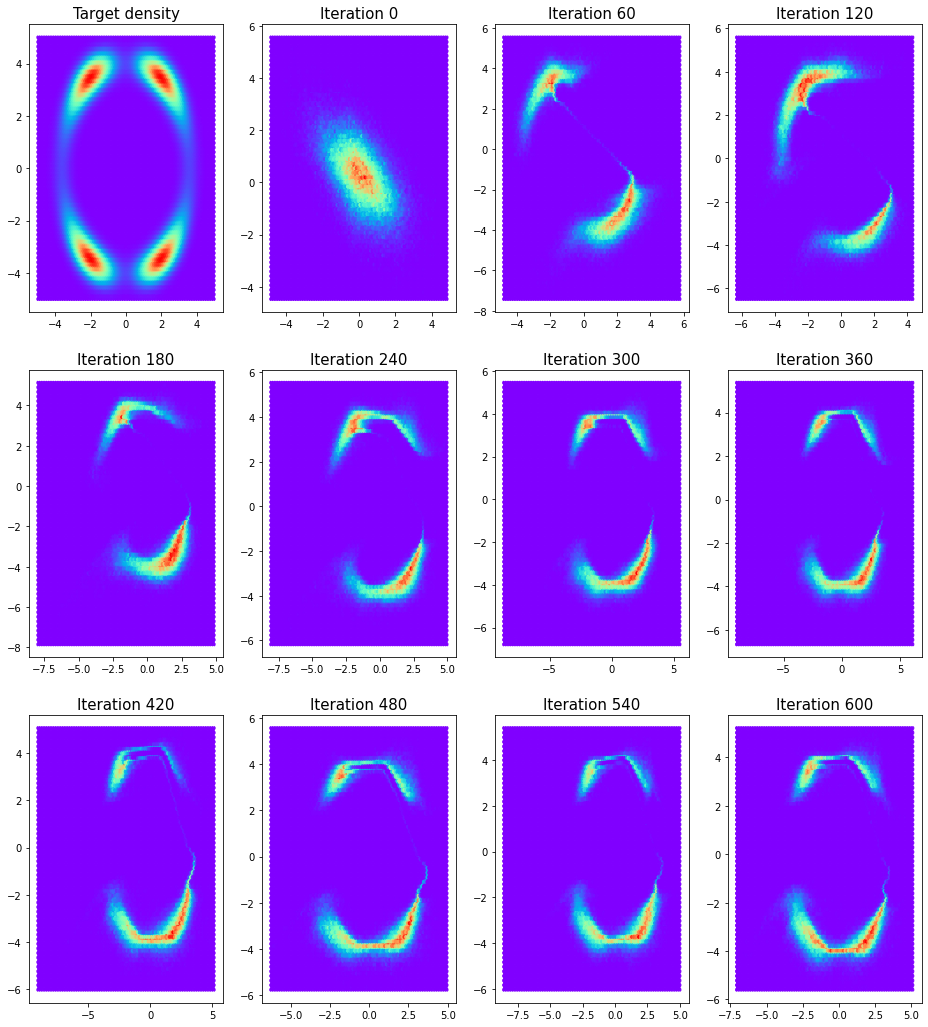

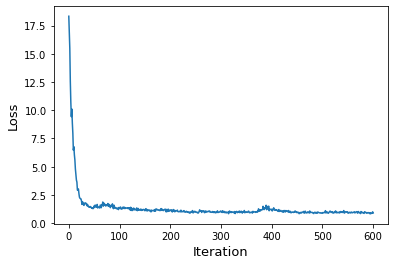

In [15]:
# train FrEIA model
train(model=inn,
      iterations=601, 
      lr=0.001,
      scheduler=0.999,
      name='freia',
      jupyter_nb=True)

In [16]:
# Check the output of the stacked flow components
model_layerwise(inn, 
                name='freia', 
                jupyter_nb=True)

ValueError: Please use "freia" or "simplemodel" for model name

In [ ]:
# Check for bijectivity

pz = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
z = pz.sample((int(10), ))

inn.cpu()
y, _ = inn(z)
z_rev, _ = inn(y, rev=True)

# inverting from the outputs should give the original inputs again
assert torch.max(torch.abs(z_rev - z)) < 1e-5